# BA, $n_\mathrm{p} = 1$, $512^2$

| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  08/06/2024          |
| Updated |  11/03/2024          |

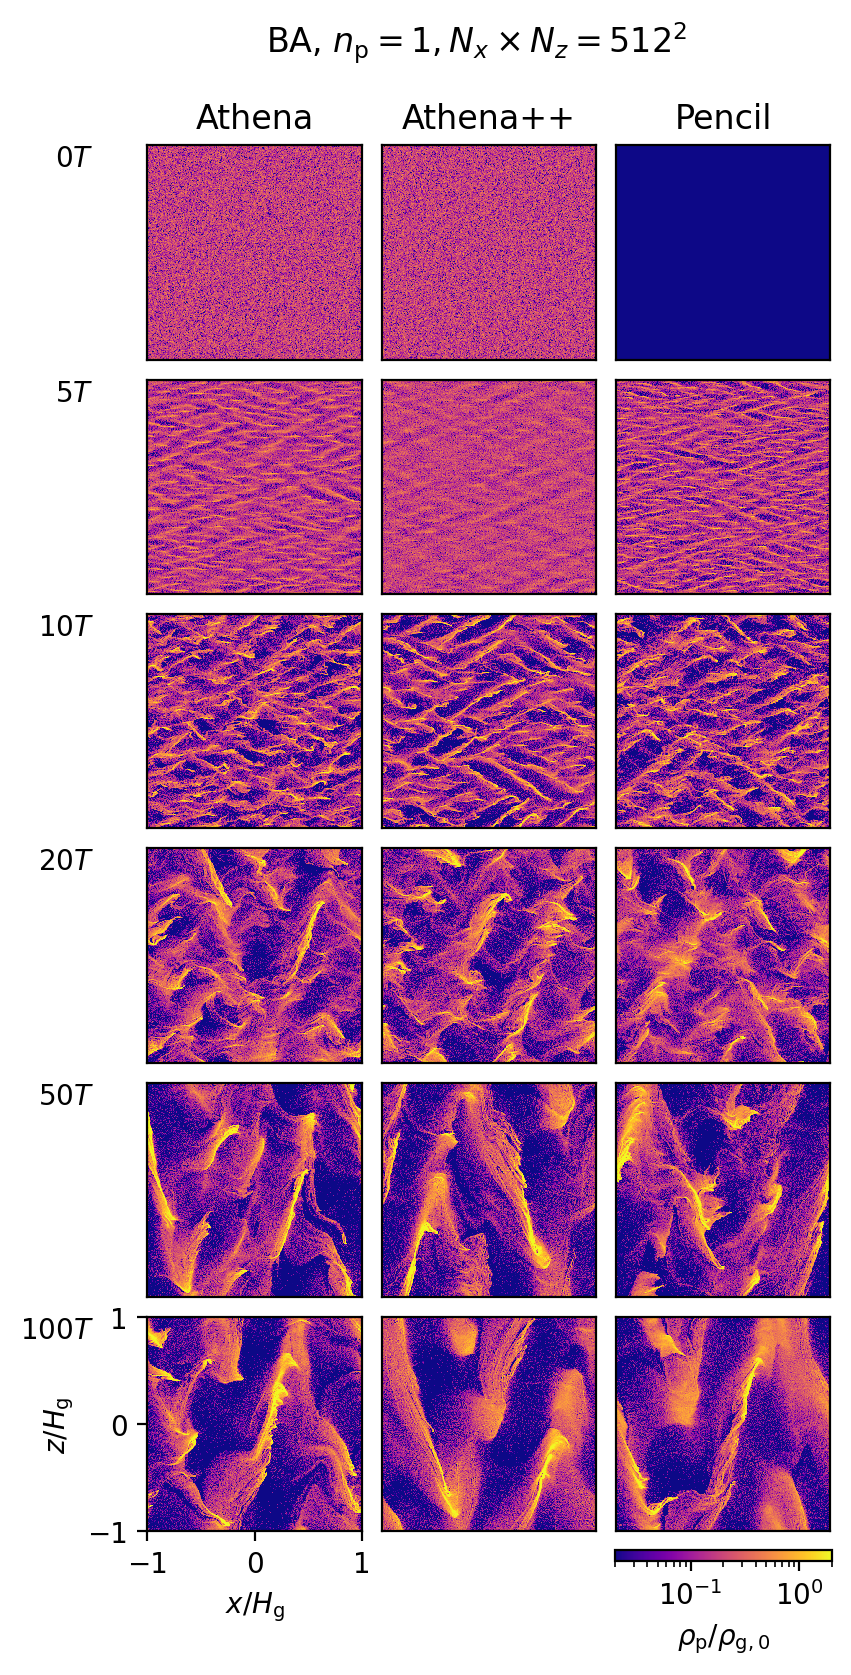

In [71]:
#===============================================================================
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
codes = ['Athena', 'Athena++', 'Pencil']
times = [0, 5, 10, 20, 50, 100]
vmin, vmax = 2e-2, 2e0 # BA CPDD > 85%; CPDD < 5%
fig = plt.figure(figsize=(5, 9), dpi=200)
if dust == 'particles':
    fig.suptitle(rf'{problem}, $n_\mathrm{{p}} = {n_p[2:]}, N_x \times N_z = {res}^2$',
                 y=0.95)
elif dust == 'fluid':
    fig.suptitle(rf'{problem}, dust fluid, $N_x \times N_z = {res}^2$',
                 y=0.95)
ax_grid = AxesGrid(fig, 111, nrows_ncols=(len(times), len(codes)),
                   direction='column', axes_pad=0.1, share_all=True,
                   label_mode='1')

for j, code in enumerate(codes):
    path = f'{root}/{model}/{problem}/{variation}/{code}'
    ax_grid[j*len(times)].set_title(code)
    for i, time in enumerate(times):
        try:
            snap = np.load(f'{path}/{time}.npz')
            x = snap['x']
            z = snap['z']
            rhop = snap['rhop']
        except FileNotFoundError:
            rhop = np.zeros_like(res**2, shape=(res, res))
        clip = np.clip(rhop, vmin, vmax)
        pcm = ax_grid[j*len(times)+i].pcolormesh(x, z, clip, cmap='plasma',
                                                 rasterized=True,
                                                 norm=colors.LogNorm(vmin=vmin,
                                                                     vmax=vmax))
        if j == 0:
            ax_grid[i].text(-0.25, 0.9, rf'{time}$T$', ha='right',
                            transform=ax_grid[i].transAxes)
        ax_grid[j*len(times)+i].tick_params(bottom=False, left=False)

x1 = ax_grid[-1].get_position().x1 + 0.02 # TODO: OPTMIZE
plt.colorbar(pcm, orientation='horizontal', shrink=0.28, anchor=(x1, -0.15),
             label=r'$\rho_\mathrm{p}/\rho_\mathrm{g,0}$')
ax_grid[len(times)-1].set(xlabel=r'$x/H_\mathrm{g}$', ylabel=r'$z/H_\mathrm{g}$')
ax_grid[len(times)-1].tick_params(bottom=True, left=True)
plt.savefig(f'{problem}-{n_p}-{res}_snapshots.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)


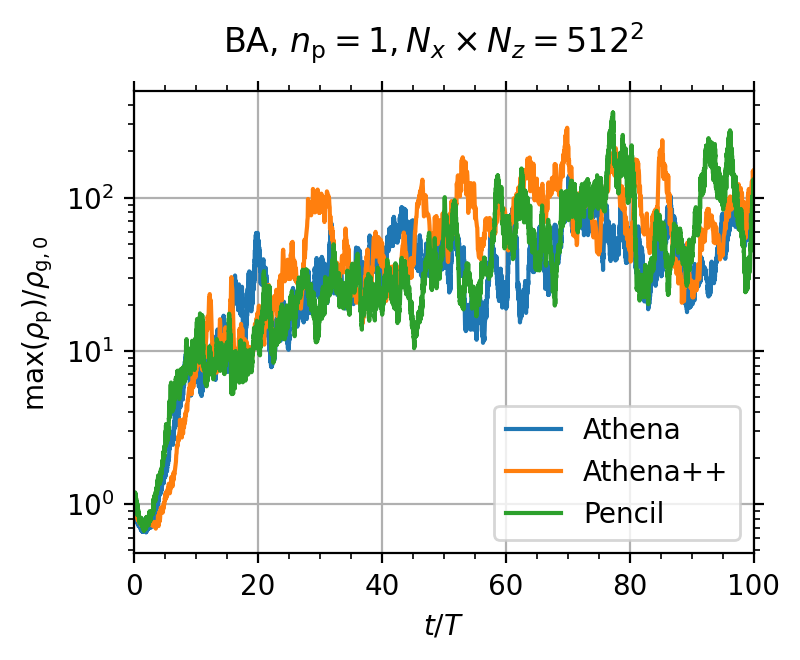

In [69]:
#===============================================================================
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
codes = ['Athena', 'Athena++', 'Pencil']
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
if dust == 'particles':
    fig.suptitle(rf'{problem}, $n_\mathrm{{p}} = {n_p[2:]}, N_x \times N_z = {res}^2$',
                 y=1)
elif dust == 'fluid':
    fig.suptitle(rf'{problem}, dust fluid, $N_x \times N_z = {res}^2$',
                 y=1)

for j, code in enumerate(codes):
    path = f'{root}/{model}/{problem}/{variation}/{code}'
    time_series = np.load(f'{path}/time_series.npz')
    ax.plot(time_series['t'], time_series['maxrhop'], label=code)

ax.grid()
ax.legend()
ax.minorticks_on()
ax.set(yscale='log', xlim=[0, 100], xlabel=r'$t/T$',
       ylabel=r'$\max(\rho_\mathrm{p})/\rho_\mathrm{g,0}$')
ax.tick_params(axis='both', which='both', top=True, right=True)
plt.savefig(f'{problem}-{n_p}-{res}_time_series.pdf', bbox_inches='tight',
            pad_inches=0.01)


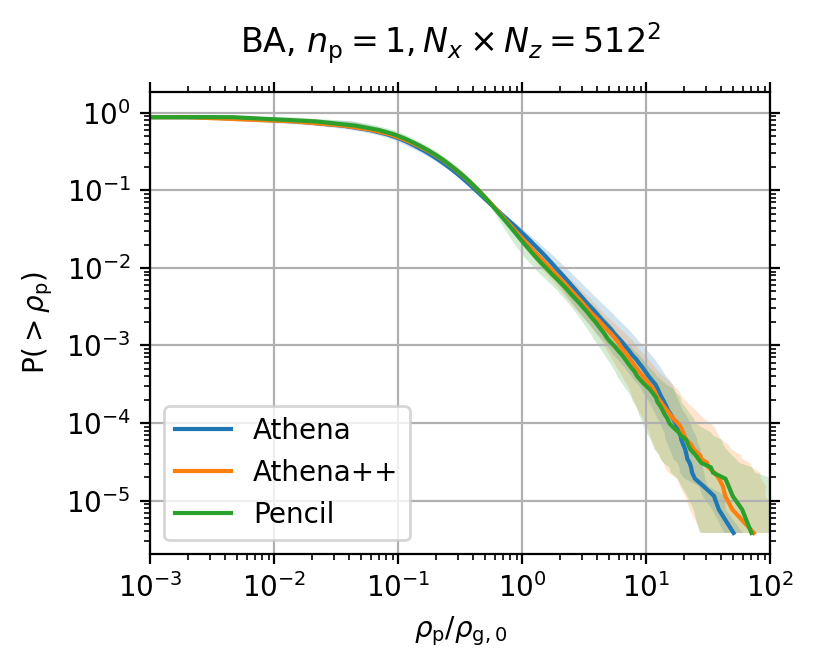

In [72]:
#===============================================================================
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import sys

# ID problem/variation/codes
root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
codes = ['Athena', 'Athena++', 'Pencil']
times = [20, 50, 100]

# Set up figure
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
if dust == 'particles':
    fig.suptitle(rf'{problem}, $n_\mathrm{{p}} = {n_p[2:]}, N_x \times N_z = {res}^2$',
                 y=1)
elif dust == 'fluid':
    fig.suptitle(rf'{problem}, dust fluid, $N_x \times N_z = {res}^2$',
                 y=1)
tab_colors = list(matplotlib.colors.TABLEAU_COLORS)

# Plot CDFs
indices = -np.unique(np.logspace(np.log2(res**2), 0, num=100, base=2,
                     dtype=int))
for j, code in enumerate(codes):
    path = f'{root}/{model}/{problem}/{variation}/{code}'
    rhops = []
    for i, time in enumerate(times):
        snap = np.load(f'{path}/{time}.npz')
        sort = np.sort(snap['rhop'], axis=None)
        rhops.append(sort)
    rhops = np.asarray(rhops)
    avgs = np.average(rhops, axis=0)
    cdf = np.linspace(1, 0, avgs.size, endpoint=False)
    log = np.log(np.clip(rhops, 1e-45, None))
    std_log = np.std(log, axis=0)
    stds = np.clip(np.exp(std_log), None, 3)
    cdf = np.take_along_axis(cdf, indices, 0)
    avgs = np.take_along_axis(avgs, indices, 0)
    stds = np.take_along_axis(stds, indices, 0)
    ax.plot(avgs, cdf, color=tab_colors[j], label=code)
    ax.fill_betweenx(cdf, avgs/stds, avgs*stds, color=tab_colors[j], ec=None,
                     alpha=0.2)

# Format plots
ax.grid()
ax.legend()
ax.minorticks_on()
ax.set(xlim=(1e-3, 1e2), xscale='log', yscale='log', 
       xlabel=r'$\rho_\mathrm{p}/\rho_\mathrm{g,0}$',
       ylabel=r'P$(>\rho_\mathrm{p})$')
ax.tick_params(axis='both', which='both', top=True, right=True)
plt.savefig(f'{problem}-{n_p}-{res}_CDF.pdf', bbox_inches='tight',
            pad_inches=0.01)

## Data compliance

### Athena

In [53]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena'
prefix = 'rhop-'
suffix = '-orbit.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'
times = [5, 10, 20, 50, 100]

# Load separate grid
grid = np.load(f'{path}/old/grid.npz', mmap_mode='r')
x = grid['x']
z = grid['z']

# Inspect
np.load(f'{path}/old/{prefix}{times[1]:04}{suffix}', mmap_mode='r').files
# np.shape(snap['rhop'])

# Exception
time = 0
snap = np.load(f'{path}/old/{prefix}{time:04}{suffix}')
np.savez_compressed(f'{path}/{time}', x=x, z=z,
                    rhop=snap['rhop'].transpose())

# Standardize
for time in times:
    snap = np.load(f'{path}/old/{prefix}{time:04}{suffix}')
    np.savez_compressed(f'{path}/{time}', x=x, z=z,
                        rhop=snap['par_density'].transpose())

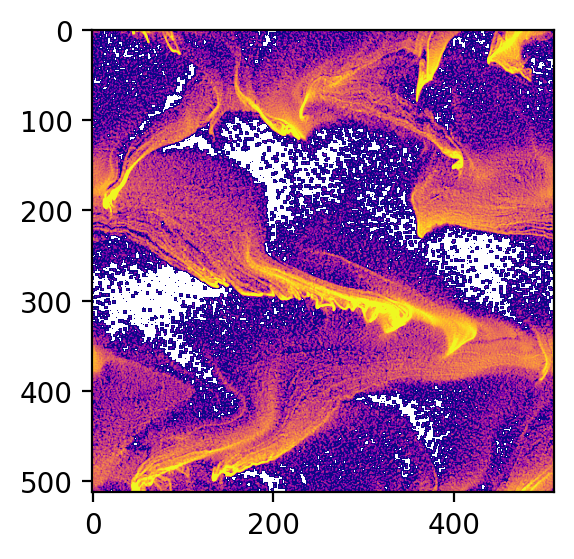

In [ ]:
snap = np.load(f'{path}/100.npz')

fig = plt.figure(figsize=(4, 3), dpi=200)
plt.imshow(snap['rhop'], cmap='plasma', norm=colors.LogNorm(vmin=2e-2, vmax=2e0))

In [57]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena'
fname = 'time_vs_max_density.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
np.load(f'{path}/old/{fname}', mmap_mode='r').files

# Standardize
time_series = np.load(f'{path}/old/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['time'],
                    maxrhop=time_series['max_density'])


### Athena++

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena++'
prefix = 'rhop'
suffix = '.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'
times = [0, 5, 10, 20, 50, 100]

# Load separate grid
grid = np.load(f'{path}/old/grid_varz.npz', mmap_mode='r')
x = grid['x']
z = grid['z']

# Inspect
np.load(f'{path}/old/{prefix}{times[1]}{suffix}', mmap_mode='r').files
# np.shape(snap['rhop'])

# Exception
# time = 0
# snap = np.load(f'{path}/old/{prefix}{time:04}{suffix}')
# np.savez_compressed(f'{path}/{time}', x=x, z=z,
#                     rhop=snap['rhop'].transpose())

# Standardize
for time in times:
    snap = np.load(f'{path}/old/{prefix}{time}{suffix}')
    np.savez_compressed(f'{path}/{time}', x=x, z=z,
                        rhop=snap['rhop'])

In [64]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena++'
fname = 'time_series_rhopmax.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
np.load(f'{path}/old/{fname}', mmap_mode='r').files

# Standardize
time_series = np.load(f'{path}/old/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['t'],
                    maxrhop=time_series['rhopmax'])


### Pencil

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Pencil'
prefix = 'rhop'
suffix = '.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'
times = [5, 10, 20, 50, 100]

# Load separate grid
grid = np.load(f'{path}/old/grid_varz.npz', mmap_mode='r')
x = grid['x']
z = grid['z']

# Inspect
np.load(f'{path}/old/{prefix}{times[1]}{suffix}', mmap_mode='r').files
# np.shape(snap['rhop'])

# Exception
# time = 0
# snap = np.load(f'{path}/old/{prefix}{time:04}{suffix}')
# np.savez_compressed(f'{path}/{time}', x=x, z=z,
#                     rhop=snap['rhop'].transpose())

# Standardize
for time in times:
    snap = np.load(f'{path}/old/{prefix}{time}{suffix}')
    np.savez_compressed(f'{path}/{time}', x=x, z=z,
                        rhop=snap['rhop'])

In [78]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np1'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Pencil'
fname = 'time_series.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
np.load(f'{path}/old/{fname}', mmap_mode='r').files
np.load(f'{path}/old/{fname}', mmap_mode='r')['t']/2/np.pi

# Standardize
time_series = np.load(f'{path}/old/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['t']/2/np.pi,
                    maxrhop=time_series['rhopmax'])
